## 목표 

1. normal, 기본 Augment과 CutMix, MixUp, Cutout 기법을 ResNet50모델에 적용하여 데이터 비교 (논문 값과 대조해보기)

2. Augmentation 적용을 통해 Augmentaion 미적용시 대비 성능향상

3. 여러가지 Augmentation 기법을 적용한 결과 정리

## STEP 0. 라이브러리 불러오기
---

In [1]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.5 MB/s 


In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow_datasets as tfds

In [3]:
# 학습 전에는 항상 GPU 환경을 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## STEP 1. Data load
---
데이터셋을 불러와서 전처리 및 Augmentation을 적용하는 함수를 만들어 적용해줍니다.

- 데이터셋 : stanford_dogs  
    - 120개 견종, 총 20,580장의 이미지 
    - 12,000장은 train, 8,580장은 test

In [51]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split = ['train', 'test'],
    shuffle_files = True,
    with_info = True,
    as_supervised = True
)

In [5]:
ds_train

<_OptionsDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [6]:
#다운로드한 데이터 확인
ds_test

<_OptionsDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

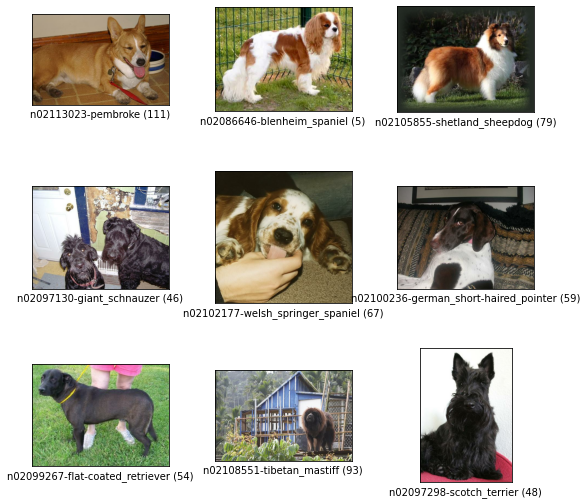

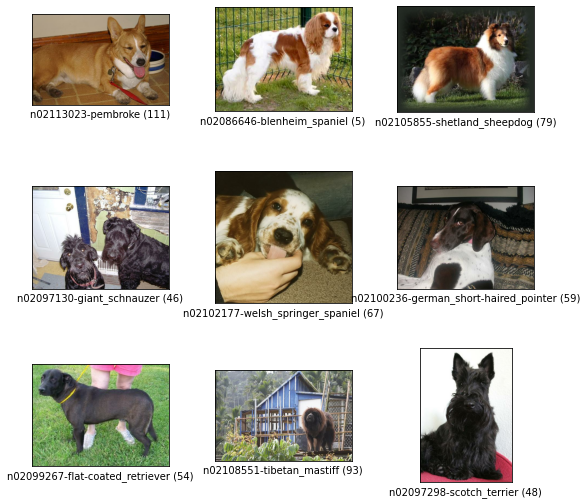

In [7]:
#다운로드한 데이터 확인
tfds.show_examples(ds_train, ds_info)

In [29]:
ds_info.splits

{'test': <tfds.core.SplitInfo num_examples=8580>,
 'train': <tfds.core.SplitInfo num_examples=12000>}

In [8]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

dataset을 로드하면 꼭 feature를 뽑아서 정보를 확인해야합니당!

In [9]:
# num_classes 정의
num_classes = ds_info.features['label'].num_classes
num_classes

120

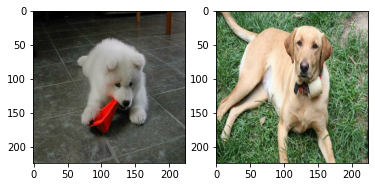

In [56]:
# 각 Augment에 적용할 이미지 2개를 가져오기
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break
        
plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

## STEP 2. Augmentation을 적용한 데이터셋 만들기
---
사용할 Augmentation은 
1. Augment (좌우반전, 밝기 조절)
2. Mix Up (일정비율로 픽셀값 합침)
3. Cut Out (랜덤하게 이미지를 잘라냄)
4. Cut Mix (랜덤하게 자른 이미지를 합침)

총 4가지이며, 아무것도 사용하지 않은 No Augmentation과 비교하여 Augmentation 영향을 살펴보려한다.

### 2-1 augment(좌우반전, 밝기 조절)
---
Augmentation은 실제 일어날 수 있을만한 상황에 맞춰 만들어 주는 것이 좋습니다.  
그래서 이번엔 좌우 반전과 밝기 조절만 하려고 합니다.

In [13]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224,224])
    
    return tf.cast(image, tf.float32) /255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

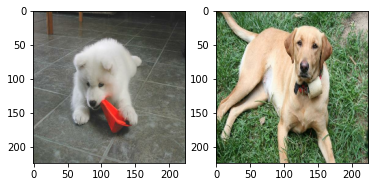

In [59]:
img_aug_1, img_aug_2 = augment(image_a, image_b)

plt.subplot(1,2,1)
plt.imshow(img_aug_1)
plt.subplot(1,2,2)
plt.imshow(img_aug_2)
plt.show()

밝기가 조절된 것이 보입니다!

### 2.2 Mixup
---
- [Mixup 논문 : mixup:Beyond Empirical Risk Minimization](https://arxiv.org/pdf/1710.09412.pdf)
- mixup Augmentaion은 간단하게 이미지의 픽셀값을 랜덤 비율로 섞어서 이미지를 나타내고, 해당 label 또한 비율값에 맞춰 섞어주는 방법입니다. 
- 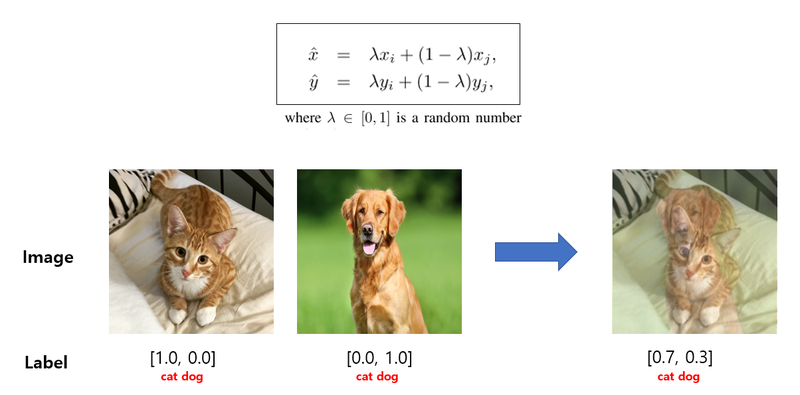
- 기본적으로 신경망은 훈련 데이터셋에 대한 평균 에러를 최소화함으로써 신경망을 최적화합니다. 이를 Empirical Risk Minimization(ERM) principle이라고 하는데, 우리가 현재 보유한 데이터의 empirical distribution(경험적 분포)을 통해서 risk(error)를 최소화하는 것입니다. 
- 이는 훈련 데이터에대해서 overfitting이 발생하는 단점이 있습니다. 따라서 ERM 기반의 학습의 신경망 일반화(Generalization)는 오직 훈련 데이터셋과 약간 다른 분포를 가진 test 데이터셋에서만 가능하게 됩니다.
- 그래서 새로운 방법인 **Vicinal Risk Minimization(VRM) principle**이 고안되었습니다. VRM 기반의 학습과 ERM 기반의 학습의 가장 큰 차이점은 훈련 데이터셋만 학습하는 것이 아니라 **훈련 데이터셋의 근방(vicinal) 분포도 함께 활용**한다는 것입니다
- 이 근방의 분포를 얻기위해 Data Augmentation을 하는 것이죠. 

- 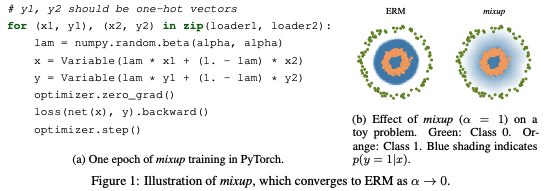
- 상기 오른쪽 이미지는 mixup을 사용한 학습결과와 사용하지않은 ERM 기반의 학습결과 입니다. 보면 decision boundary차이가 보이는데, ERM은 두 클래스간의 decision boundary가 명확하고 정확하게 분리가 됩니다. 하지만 mixup을 사용한 것은 decision boundary가 blurry한 것을 볼 수 있습니다. 이는 ERM에 비해 overfitting이 덜 발생한다는 것이며, mixup이 regularization의 역할도 한다고 볼 수 있습니다. 

- [참고 블로그](https://everyday-image-processing.tistory.com/145)

In [14]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

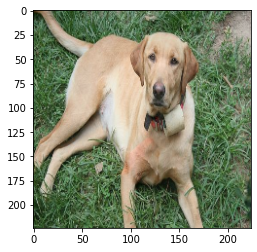

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.8512864  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [61]:
mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()

print(mixed_label)

라벨 값을 통해 두 이미지가 약 85 : 15 비율로 섞인 것을 알 수 있습니다!

In [15]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('Mixup 함수 완료!')

Mixup 함수 완료!


### 2-3 CutOut
---
- [cutout논문 : Improved Regularization of Convolutional Neural Networks with Cutout](https://arxiv.org/pdf/1708.04552v2.pdf)
- 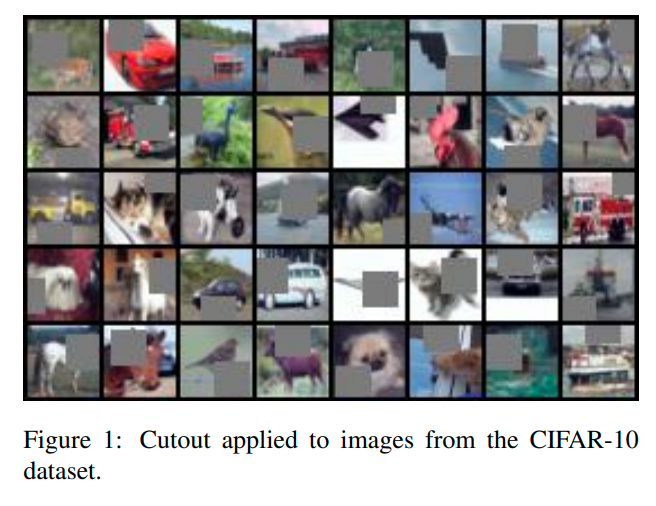
- cutout은 이미지에서 사각형으로 랜덤하게  잘라내서 0으로 마스킹하는 방법입니다(noise로 마스킹하면 Erasing). 이를 통해 Regularization과 Augmentation을 동시에 해결합니다. CNN의 overfitting 방지와 성능개선을 이뤄냅니다. 
- Cut Out은 object detecting시 객체의 일부분이 가려지는 object occlusion 문제를 개선하기 위해 고안되었습니다. 모델 학습시 잘려진 이미지를 넣어줌으로 test 데이터셋에서 object occlusion이 있어도 더 잘 판단할 수 있습니다. 
- 이전의 Out-of-Distribution Examples 논문에서는 스크래치나 점, 갈겨쓴 모양 등을 이미지에 합성시켜 이미지를 가리는 방식을 사용하였고, cutout은 0으로 채워넣는 방식입니다.
- 또한 0으로 채워넣는 것을 보면, 학습 단계에서 Network의 hidden unit activation을 일정 확률로 0으로 바꾸는 Dropout과 비슷합니다. 하지만 cutout은 중간에서 생성된 feature map이 아닌 input image 에서 0으로 채운다는 점에서 차이가 있습니다. 
- Dropout은 중간 단계의 layer의 feature map에서만 random하게 일부 영역을 지우고 각 feature map의 channel간 독립성이 존재하여 어떤 channel에서는 지워진 영역이 다른 channel에서는 지워지지 않게 되어 불일치성이 일부 존재하게 됩니다. 하지만 Cutout은 입력 단계에서 일부 영역을 지우고 그 결과 중간 단계의 layer에서도 같은 영역 주위를 지우는 것과 같은 효과를 볼 수 있으며 각 feature map의 channel간에도 상관 관계를 갖게 됩니다.

- [관련 블로그](https://hoya012.github.io/blog/Improved-Regularization-of-Convolutional-Neural-Networks-with-Cutout-Review/)

In [16]:
####### cut out 함수 ###########
# def cutout(images, labels):
#     cutout_imgs = tfa.image.random_cutout(images, (64, 64), constant_values = 1)
#     cutout_imgs = tf.reshape(tf.stack(cutout_imgs), (16, 224, 224, 3))
#     return cutout_imgs, labels

In [91]:
####### cut out 클래스 ###########
class Cutout(object):
    def __init__(self, cutout_width):
        # width of the square to occlude
        self.cutout_width = cutout_width

    def __call__(self, img):
        h = img.shape[0]
        w = img.shape[1]

        mask = np.ones(img.shape)

        y = np.random.randint(h)
        x = np.random.randint(w)

        x1 = np.clip(x - self.cutout_width // 2, 0, w)
        x2 = np.clip(x + self.cutout_width // 2, 0, w)

        y1 = np.clip(y - self.cutout_width // 2, 0, h)
        y2 = np.clip(y + self.cutout_width // 2, 0, h)

        mask[y1: y2, x1: x2] = 0.0

        # occlude the part of image using mask (zero out the part)
        img = img * mask

        return img

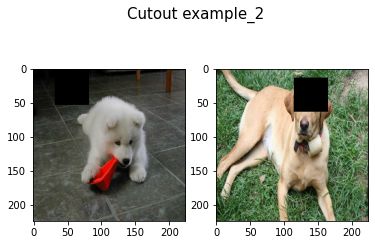

In [93]:
cutout = Cutout(50)
plt.subplot(1,2,1)
plt.imshow(cutout(image_a))
plt.suptitle("Cutout example_1",fontsize=15)

plt.subplot(1,2,2)
plt.imshow(cutout(image_b))
plt.suptitle("Cutout example_2",fontsize=15)

plt.show()

왼쪽 상단과 개의 얼굴에 cutout box가 생긴것이 보입니다!

### 2-4. Cutmix Augmentation
---
- [Cutmix 논문: CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features](https://arxiv.org/pdf/1905.04899.pdf)
- [캐글 예시 : Chris Deotte's CutMix and MixUp on GPU/TPU](https://www.kaggle.com/code/cdeotte/cutmix-and-mixup-on-gpu-tpu/notebook)

- CutMix는 말그대로 데이터를 자르고 섞는 방법입니다.  Mixup은 특정 비율로 픽셀별 값을 섞는 방식이고, Cutout은 이미지를 잘라내는 방식입니다. CutMix는 Mixup과 비슷하지만 일정 영역을 잘라서 붙여주는 방법입니다.   
- CutMix는 모델이 이미지의 객체 특징에 집중하지 않고, 덜 구분되는 부분 및 이미지의 전체적인 특징을 보고 학습하도록 하여 일반화와 localization 성능을 높이는 방법입니다.  
- train set과 test set의 분포가 다른 경우를 의미하는 OOD(out of distribution)와 이미지가 가려진 sample, adversarial sample에서의 robustness도 좋은 성능을 나타냅니다.
- 아래에서 진행해볼 NO augmentation, Mixup, Cutout, Cutmix의 비료 표입니다. classification, Localization, Detection 3가지 task에서 성능강화가 일어난 것을 보여주고 있습니다. 
- 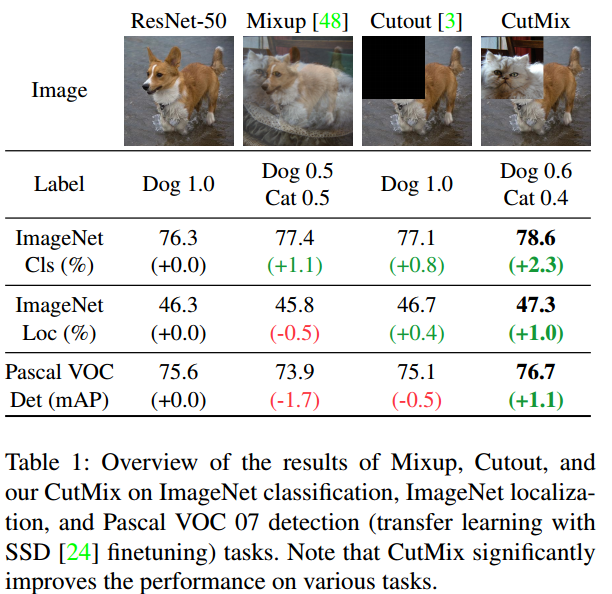

In [17]:
########## Boundering Box 함수 ##########
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    #get boundering box 
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)
    
    # get width, height of box 
    # 이 w, h를 통해 box size결정 -> 데이터 결합비율 결정됨
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bounding box
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

In [18]:
# mix two images
def mix_2_image(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[0]
    image_size_y = image_b.shape[1]
    # image_b의 왼쪽 바깥 영역
    middle_left = image_a[y_min:y_max, 0:x_min, :] 
    # image_b의 안쪽 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]
    # image_b의 오른쪽 바깥 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :]
    
    middle = tf.concat([middle_left, middle_center, middle_right], axis = 1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    
    mixed_image = tf.concat([top, middle, bottom], axis = 0)
    
    return mixed_image

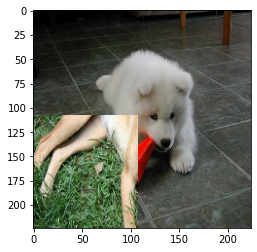

In [63]:
x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

mixed_image = mix_2_image(image_a, image_b, x_min, y_min, x_max, y_max)

plt.imshow(mixed_image)
plt.show()

다리가 묘하게 겹쳐있는 그림이 나옵니다!

In [19]:
######### 라벨 Mix ###########
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    # image_size_x = image_a.shape[1]
    image_size_x = 224
    # image_size_y = image_a.shape[0]
    image_size_y = 224
    mixed_area = (x_max - x_min) * (y_max - y_min)
    total_area = image_size_x * image_size_y
    ratio = tf.cast(mixed_area / total_area, tf.float32)
    
    if len(label_a.shape) == 0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape) == 0:
        label_b = tf.one_hot(label_b, num_classes)
        
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_label

In [20]:
############ 전체 Cut Mix 함수 ##############
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, 
num_classes=120):
    
    mixed_imgs = []
    mixed_labels = []
    
    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        
        mixed_imgs.append(mix_2_image(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))
    
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

print('Cut Mix 함수 완룡!')

Cut Mix 함수 완룡!


### 2-5 데이터셋에 각각 적용 하기

In [52]:
ds_train = ds_train.map(normalize_and_resize_img, num_parallel_calls = 2)
ds_test = ds_test.map(normalize_and_resize_img, num_parallel_calls = 2)
ds_test = ds_test.map(onehot, num_parallel_calls=2)
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(batch_size = 16)

In [53]:
########## 데이터 셋에 적용 함수 ##########
def apply_normalize_on_dataset(ds, 
                               batch_size = 16,
                               is_test = False,
                               with_aug = False,
                               with_mixup = False,
                               with_cutout = False,
                               with_cutmix = False
                               ):
    ds = ds.batch(batch_size)
    # 1. augument
    if not is_test and with_aug:
        ds = ds.map(augment, num_parallel_calls = 2)

    # 2. mixup    
    if not is_test and with_mixup:
        ds = ds.map(mixup, num_parallel_calls = 2)

    # 3. cutout
    if not is_test and with_cutout:
        ds = ds.map(cutout, num_parallel_calls = 2)

    # 4. cutmix 
    if not is_test and with_cutmix:
        ds = ds.map(cutmix, num_parallel_calls = 2)

    # 5. no augmentation
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)   

    if not is_test and not (with_mixup or with_cutmix):
        ds = ds.map(onehot, num_parallel_calls=2)

    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

    return ds

이제 각 augmentation을 적용한 dataset을 생성해 줍니다.

In [54]:
# 1. augument
ds_train_aug = apply_normalize_on_dataset(ds_train,
                                         with_aug = True)
# 2. mixup 
ds_train_mixup = apply_normalize_on_dataset(ds_train,
                                         with_mixup = True)
# 3. cutout
ds_train_cutout = apply_normalize_on_dataset(ds_train,
                                         with_cutout = True)
# 4. cutmix 
ds_train_cutmix = apply_normalize_on_dataset(ds_train,
                                         with_cutmix = True)
# 5. no augmentation
ds_train_no_aug = apply_normalize_on_dataset(ds_train, 
                                             with_aug=False)

print('데이터셋 준비 완료')

데이터셋 준비 완료


In [55]:
print(ds_train_no_aug.take(1))
print(ds_train_cutout.take(1))
print(ds_test.take(1))

<TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>
<TakeDataset element_spec=(TensorSpec(shape=(16, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>
<TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>


모든 데이터셋이 잘 적용되어 있는것을 확인했습니다!

## STEP 3. 모델 제작 및 훈련하기
---
- 모델은 pretrain된 ResNet-50을 사용하며 각 augmentation 상황에 맞춰 모델을 따로 생성하여 훈련시켜줍니다. 

1.  No Augmentation
2. 기본 + Augmentation
3. 기본 + CutMix 적용
4. 기본 + Cutout 적용
5. 기본 + Mixup 적용


### 3-1. No Augmentation

In [26]:
######### 1. No Augmentation ##########
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('1. No Augmentation ResNet')

1. No Augmentation ResNet


In [27]:
EPOCH = 20 

resnet50.compile(loss = 'categorical_crossentropy',
                 optimizer = tf.keras.optimizers.SGD(learning_rate=0.01),
                 metrics = ['accuracy'])

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # no augmentation 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 103s 122ms/step - loss: 2.2378 - accuracy: 0.4391 - val_loss: 3.4904 - val_accuracy: 0.1851
Epoch 2/20
750/750 [==============================] - 90s 121ms/step - loss: 0.6724 - accuracy: 0.8227 - val_loss: 1.0809 - val_accuracy: 0.6868
Epoch 3/20
750/750 [==============================] - 90s 121ms/step - loss: 0.1839 - accuracy: 0.9659 - val_loss: 0.9199 - val_accuracy: 0.7267
Epoch 4/20
750/750 [==============================] - 90s 121ms/step - loss: 0.0479 - accuracy: 0.9968 - val_loss: 0.8948 - val_accuracy: 0.7396
Epoch 5/20
750/750 [==============================] - 90s 121ms/step - loss: 0.0229 - accuracy: 0.9993 - val_loss: 0.9336 - val_accuracy: 0.7355
Epoch 6/20
750/750 [==============================] - 90s 121ms/step - loss: 0.0377 - accuracy: 0.9970 - val_loss: 0.9419 - val_accuracy: 0.7343
Epoch 7/20
750/750 [==============================] - 90s 120ms/step - loss: 0.0136 - accuracy: 0.9995 - val_loss: 0.9273 - val_a

### 3-2 Augment(좌우반전, 밝기조절)


In [29]:
######### 2. Normal Augumentation ##########
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('2. Normal Augumentation Resnet')

2. Normal Augumentation Resnet


In [30]:
EPOCH = 20 

aug_resnet50.compile(loss = 'categorical_crossentropy',
                 optimizer = tf.keras.optimizers.SGD(learning_rate=0.01),
                 metrics = ['accuracy'])

history_aug_resnet50 = aug_resnet50.fit(
    ds_train_aug, # augmentation 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 102s 126ms/step - loss: 2.2855 - accuracy: 0.4245 - val_loss: 2.7704 - val_accuracy: 0.3055
Epoch 2/20
750/750 [==============================] - 94s 125ms/step - loss: 0.9119 - accuracy: 0.7442 - val_loss: 1.1960 - val_accuracy: 0.6500
Epoch 3/20
750/750 [==============================] - 93s 124ms/step - loss: 0.4518 - accuracy: 0.8806 - val_loss: 1.0316 - val_accuracy: 0.6953
Epoch 4/20
750/750 [==============================] - 93s 124ms/step - loss: 0.2341 - accuracy: 0.9467 - val_loss: 0.9520 - val_accuracy: 0.7252
Epoch 5/20
750/750 [==============================] - 93s 124ms/step - loss: 0.1212 - accuracy: 0.9782 - val_loss: 0.9895 - val_accuracy: 0.7255
Epoch 6/20
750/750 [==============================] - 93s 124ms/step - loss: 0.0680 - accuracy: 0.9909 - val_loss: 1.0000 - val_accuracy: 0.7231
Epoch 7/20
750/750 [==============================] - 93s 124ms/step - loss: 0.0428 - accuracy: 0.9952 - val_loss: 0.9497 - val_a

### 3-3. Mixup

In [85]:
######### 3. MixUp Augumentation ##########
mixup_resnet_50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('3. MixUp Augumentation')

3. MixUp Augumentation


In [86]:
EPOCH = 20 

mixup_resnet_50.compile(loss = 'categorical_crossentropy',
                 optimizer = tf.keras.optimizers.SGD(learning_rate=0.01),
                 metrics = ['accuracy'])

history_mixup_resnet_50 = mixup_resnet_50.fit(
    ds_train_mixup, # mixup augmentation 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 102s 126ms/step - loss: 3.7236 - accuracy: 0.2383 - val_loss: 3.9761 - val_accuracy: 0.1123
Epoch 2/20
750/750 [==============================] - 94s 126ms/step - loss: 2.8834 - accuracy: 0.4704 - val_loss: 1.3900 - val_accuracy: 0.6052
Epoch 3/20
750/750 [==============================] - 94s 126ms/step - loss: 2.5937 - accuracy: 0.5743 - val_loss: 1.2528 - val_accuracy: 0.6423
Epoch 4/20
750/750 [==============================] - 94s 126ms/step - loss: 2.3645 - accuracy: 0.6629 - val_loss: 1.2434 - val_accuracy: 0.6583
Epoch 5/20
750/750 [==============================] - 96s 129ms/step - loss: 2.2506 - accuracy: 0.7067 - val_loss: 1.2440 - val_accuracy: 0.6596
Epoch 6/20
750/750 [==============================] - 94s 125ms/step - loss: 2.1585 - accuracy: 0.7494 - val_loss: 1.3422 - val_accuracy: 0.6455
Epoch 7/20
750/750 [==============================] - 94s 126ms/step - loss: 2.0508 - accuracy: 0.7788 - val_loss: 1.2300 - val_a

### 3-4 Cutout

In [33]:
######### 4. Cutout Augumentation ##########
cutout_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('4. Cutout Augumentation')

4. Cutout Augumentation


In [34]:
EPOCH = 20 

cutout_resnet50.compile(loss = 'categorical_crossentropy',
                 optimizer = tf.keras.optimizers.SGD(learning_rate=0.01),
                 metrics = ['accuracy'])

history_cutout_resnet50 = cutout_resnet50.fit(
    ds_train_cutout, # cutout augmentation 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 98s 120ms/step - loss: 2.5120 - accuracy: 0.3824 - val_loss: 3.5332 - val_accuracy: 0.1923
Epoch 2/20
750/750 [==============================] - 89s 118ms/step - loss: 1.1012 - accuracy: 0.6898 - val_loss: 1.2493 - val_accuracy: 0.6378
Epoch 3/20
750/750 [==============================] - 89s 118ms/step - loss: 0.7011 - accuracy: 0.8102 - val_loss: 1.1048 - val_accuracy: 0.6809
Epoch 4/20
750/750 [==============================] - 89s 118ms/step - loss: 0.3772 - accuracy: 0.9057 - val_loss: 1.0765 - val_accuracy: 0.6972
Epoch 5/20
750/750 [==============================] - 89s 119ms/step - loss: 0.2184 - accuracy: 0.9537 - val_loss: 1.1242 - val_accuracy: 0.6855
Epoch 6/20
750/750 [==============================] - 89s 119ms/step - loss: 0.1574 - accuracy: 0.9701 - val_loss: 0.9889 - val_accuracy: 0.7250
Epoch 7/20
750/750 [==============================] - 90s 120ms/step - loss: 0.1181 - accuracy: 0.9791 - val_loss: 1.1081 - val_ac

### 3-5 Cutmix

In [84]:
######### 5. CutMix Augumentation ##########
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('5. CutMix Augumentation')

5. CutMix Augumentation


In [36]:
EPOCH = 20 

cutmix_resnet50.compile(loss = 'categorical_crossentropy',
                 optimizer = tf.keras.optimizers.SGD(learning_rate=0.01),
                 metrics = ['accuracy'])

history_cutmix_resnet50 = cutmix_resnet50.fit(
    ds_train_cutmix, # no augmentation 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 99s 122ms/step - loss: 3.8482 - accuracy: 0.2082 - val_loss: 2.9904 - val_accuracy: 0.2603
Epoch 2/20
750/750 [==============================] - 91s 121ms/step - loss: 2.9398 - accuracy: 0.4415 - val_loss: 1.3516 - val_accuracy: 0.6189
Epoch 3/20
750/750 [==============================] - 91s 121ms/step - loss: 2.6359 - accuracy: 0.5280 - val_loss: 1.3757 - val_accuracy: 0.6212
Epoch 4/20
750/750 [==============================] - 91s 122ms/step - loss: 2.4198 - accuracy: 0.6084 - val_loss: 1.2315 - val_accuracy: 0.6590
Epoch 5/20
750/750 [==============================] - 91s 121ms/step - loss: 2.2894 - accuracy: 0.6485 - val_loss: 1.2208 - val_accuracy: 0.6684
Epoch 6/20
750/750 [==============================] - 91s 121ms/step - loss: 2.1763 - accuracy: 0.6794 - val_loss: 1.1310 - val_accuracy: 0.6932
Epoch 7/20
750/750 [==============================] - 91s 121ms/step - loss: 2.0439 - accuracy: 0.7230 - val_loss: 1.2034 - val_ac

## STEP 4. 모델 학습 결과 시각화
---
20 epoch을 돌린 모델들의 학습결과를 시각화하여 augmentation에 따른 효과를 비교해보려고합니다.  

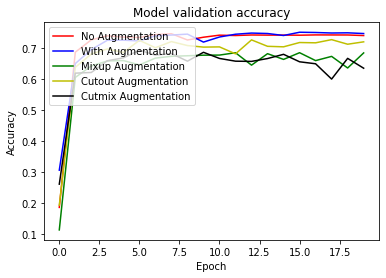

In [91]:
########### 모델 시각화 #########
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_aug_resnet50.history['val_accuracy'], 'b')
plt.plot(history_mixup_resnet_50.history['val_accuracy'], 'g')
plt.plot(history_cutout_resnet50.history['val_accuracy'], 'y')
plt.plot(history_cutmix_resnet50.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'Mixup Augmentation', 'Cutout Augmentation', 'Cutmix Augmentation'], loc='upper left')
plt.show()

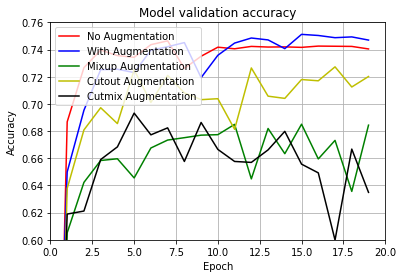

In [92]:
######### 확대샷 ############
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_aug_resnet50.history['val_accuracy'], 'b')
plt.plot(history_mixup_resnet_50.history['val_accuracy'], 'g')
plt.plot(history_cutout_resnet50.history['val_accuracy'], 'y')
plt.plot(history_cutmix_resnet50.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'Mixup Augmentation', 'Cutout Augmentation', 'Cutmix Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.6, 0.76)    # 확대할  Accuracy 범위를 지정
plt.xlim(0, 20)
plt.show()

- 목표했던 Augmentation의 Accuracy가 5% 증가하는 것이 아닌 No Augmentation이 5% 증가한 것을 볼 수 있다... 
- 또한 다양한 Augment 방법 중 일반 Augmentation이 효과가 가장 좋은 것으로 나왔다.   
- 하지만 이것은 epoch 20정도의 짧은 학습으로 인한 결과라 별로 신뢰성이 가지 않는다. 논문을 봐도 한 150~200 epoch 정도는 지나야 mixup 이나 cutmix 같은 augmentation의 효과가 나오는 것을 알 수 있다. 
- 이같은 결과는 일반 데이터셋은 전체 이미지를 통해 부분적으로 몇가지의 강한 특징을 뽑아내 빠르게 학습하는 반면, cutmix 같은 augmentation은 이미지의 일부에서 부분적인 특징들 까지 뽑아내 더 많은 특징들을 갖고 학습하게 되는 것 같다.

- 따라서 augmentation은 더 많은 특징을 줌으로 학습하는데 시간은 더 오래 걸리지만, epoch을 길게주고 더 많이 학습을 시키면 다양한 특징들에 의해 더 강화된 모델이 된다는 것 같다. 


## STEP 5. 추가 학습
---

### 추가학습 1. Mixup & Cutmix 200 epoch
---
논문을 보니 20~150 epoch에는 mixup과 Cutmix이 일반보다 안좋은 것이 보인다. 그래서 이대로 결과를 내기엔 아쉬워 두개만 200 epoch을 부여하고 논문대로 추가 비교를 진행해보려고한다. 

In [ ]:
######### 3. MixUp Augumentation ##########
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [45]:
EPOCH = 200

mixup_resnet50.compile(loss = 'categorical_crossentropy',
                 optimizer = tf.keras.optimizers.SGD(learning_rate=0.01),
                 metrics = ['accuracy'])

history_mixup_resnet50 = mixup_resnet50.fit(
    ds_train_mixup, # mixup augmentation 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/200
750/750 [==============================] - 99s 123ms/step - loss: 1.6664 - accuracy: 0.8774 - val_loss: 1.3456 - val_accuracy: 0.6655
Epoch 2/200
750/750 [==============================] - 91s 122ms/step - loss: 1.6715 - accuracy: 0.8703 - val_loss: 1.3905 - val_accuracy: 0.6549
Epoch 3/200
750/750 [==============================] - 92s 122ms/step - loss: 1.6226 - accuracy: 0.8823 - val_loss: 1.4999 - val_accuracy: 0.6456
Epoch 4/200
750/750 [==============================] - 92s 122ms/step - loss: 1.6246 - accuracy: 0.8786 - val_loss: 1.3834 - val_accuracy: 0.6644
Epoch 5/200
750/750 [==============================] - 92s 122ms/step - loss: 1.6199 - accuracy: 0.8828 - val_loss: 1.5015 - val_accuracy: 0.6372
Epoch 6/200
750/750 [==============================] - 92s 123ms/step - loss: 1.6048 - accuracy: 0.8810 - val_loss: 1.5178 - val_accuracy: 0.6329
Epoch 7/200
750/750 [==============================] - 93s 124ms/step - loss: 1.5826 - accuracy: 0.8851 - val_loss: 1.6105 -

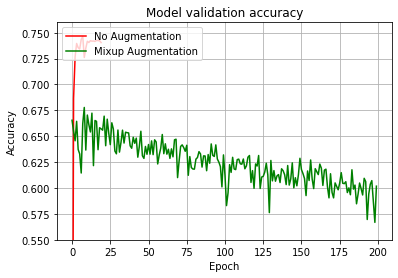

In [51]:
######### 확대샷 ############
plt.plot(history_resnet50_200.history['val_accuracy'], 'r')
plt.plot(history_mixup_resnet50.history['val_accuracy'], 'g')
# plt.plot(history_cutmix_resnet50.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Mixup Augmentation', 'Cutmix Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.55, 0.76)    
plt.show()

아래 논문의 결과를 봤을 때 200 epoch 내에서 확연한 차이를 보이는 것에 비해 overfitting의 길을 걷고있는 결과를 보니 모델의 차이, input data의 차이가 큰 것 같다.

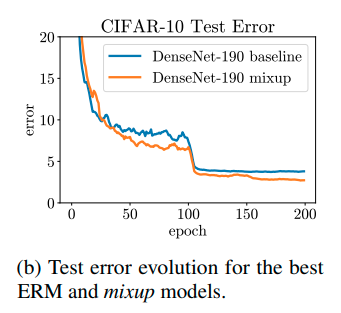

모델의 견고성도 떨어지고.. 5-6시간을 들여 돌린 것에 비해 결과가 별로라 좋진 않지만, 이를 통해 **200 epoch정도를 한다면 더 견고한 모델을 사용해야 한다는 것**을 알게 되었다. 

또한 해당 모델의 결과값이 loss, accuracy, val_loss는 비슷한데 val_accuracy는 감소하는 것은 어떤 현상인가 생각이 든다. val_accuracy가 감소하여 학습이 더이상 진행이 되지 않는 것으로 보아 overffiting이 발생하는 것은 맞으나 다른 효과가 발생한 것 같다.   

그럼 이 ResNet 50의 모델로 학습을 시킬땐 보통 augmentation을 넣고 학습을 시키는게 가장 좋을까? 


### 추가학습 2. cutout + labelsmoothing 
---
- 지난번 챗봇에대해 실습할 때 Label smoothing에 대해 공부했으나 loss값이 맞지 않아 사용하지 못해 아쉬웠던 기억이 있다. ([챗봇 실습 github](https://github.com/Chabbbbbo/EXPLORATION/blob/main/EX-11/%5BE-11%5D%20Creative%20a%20Korean%20Chatbot.ipynb)) 
- 근데 이번에 cutout에대해 공부하다보니 cutout + Label smoothing (alpha = 0.1)을 하면 loss율이 더 낮아진다는 논문을 발견해서 한번 비교해보려고한다!
- 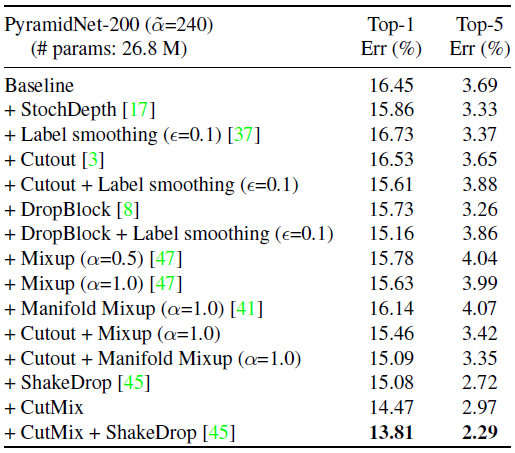
- [Label Smoothing 이해하기](https://ratsgo.github.io/insight-notes/docs/interpretable/smoothing)
- [라벨 스무딩을 이용한 모델 성능 개선](https://3months.tistory.com/465)

In [ ]:
######### Cutout Augumentation + Label smoothing ##########
cutout_labelsmoothing_resnet50_ = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [68]:
EPOCH = 50

cutout_labelsmoothing_resnet50_.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.1),
                 optimizer = tf.keras.optimizers.SGD(learning_rate=0.01),
                 metrics = ['accuracy'])

history_cutout_labelsmoothing_resnet50 = cutout_labelsmoothing_resnet50_.fit(
    ds_train_cutout, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
750/750 [==============================] - 108s 129ms/step - loss: 2.9937 - accuracy: 0.3728 - val_loss: 3.2319 - val_accuracy: 0.2828
Epoch 2/50
750/750 [==============================] - 94s 126ms/step - loss: 1.8603 - accuracy: 0.6831 - val_loss: 1.9215 - val_accuracy: 0.6559
Epoch 3/50
750/750 [==============================] - 94s 125ms/step - loss: 1.4586 - accuracy: 0.8358 - val_loss: 1.8261 - val_accuracy: 0.6827
Epoch 4/50
750/750 [==============================] - 93s 124ms/step - loss: 1.2291 - accuracy: 0.9236 - val_loss: 1.8021 - val_accuracy: 0.6988
Epoch 5/50
750/750 [==============================] - 93s 125ms/step - loss: 1.1425 - accuracy: 0.9513 - val_loss: 1.8221 - val_accuracy: 0.6976
Epoch 6/50
750/750 [==============================] - 93s 124ms/step - loss: 1.0406 - accuracy: 0.9776 - val_loss: 1.8283 - val_accuracy: 0.6985
Epoch 7/50
750/750 [==============================] - 93s 124ms/step - loss: 0.9993 - accuracy: 0.9842 - val_loss: 1.7903 - val_a

In [ ]:
######### Cutout Augumentation ##########
cutout_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [70]:
EPOCH = 50 

cutout_resnet50.compile(loss = 'categorical_crossentropy',
                 optimizer = tf.keras.optimizers.SGD(learning_rate=0.01),
                 metrics = ['accuracy'])

history_cutout_resnet50 = cutout_resnet50.fit(
    ds_train_cutout,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
750/750 [==============================] - 104s 125ms/step - loss: 2.5025 - accuracy: 0.3827 - val_loss: 3.4012 - val_accuracy: 0.1929
Epoch 2/50
750/750 [==============================] - 93s 124ms/step - loss: 1.0936 - accuracy: 0.6919 - val_loss: 1.6068 - val_accuracy: 0.5532
Epoch 3/50
750/750 [==============================] - 93s 124ms/step - loss: 0.6507 - accuracy: 0.8207 - val_loss: 1.0392 - val_accuracy: 0.6962
Epoch 4/50
750/750 [==============================] - 93s 124ms/step - loss: 0.3681 - accuracy: 0.9093 - val_loss: 1.1138 - val_accuracy: 0.6849
Epoch 5/50
750/750 [==============================] - 93s 124ms/step - loss: 0.2126 - accuracy: 0.9558 - val_loss: 1.0545 - val_accuracy: 0.7002
Epoch 6/50
750/750 [==============================] - 93s 124ms/step - loss: 0.1456 - accuracy: 0.9722 - val_loss: 1.1826 - val_accuracy: 0.6793
Epoch 7/50
750/750 [==============================] - 93s 125ms/step - loss: 0.1123 - accuracy: 0.9805 - val_loss: 1.0024 - val_a

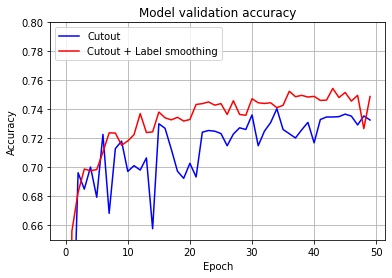

In [98]:
######### 비교 시각화 ############
plt.plot(history_cutout_resnet50.history['val_accuracy'], 'b')
plt.plot(history_cutout_labelsmoothing_resnet50.history['val_accuracy'], 'r')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Cutout', 'Cutout + Label smoothing'], loc='upper left')
plt.grid(True)
plt.ylim(0.65, 0.8)  
plt.show()

아... 이쁘다...! 확실히 Label Smoothing을 사용한 model의 accuracy가 높은 것이 보입니다...ㅎㅎ

(0.65, 0.76)

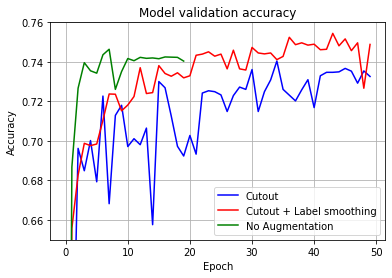

In [97]:
plt.plot(history_cutout_resnet50.history['val_accuracy'], 'b')
plt.plot(history_cutout_labelsmoothing_resnet50.history['val_accuracy'], 'r')
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Cutout', 'Cutout + Label smoothing', 'No Augmentation'], loc='lower right')
plt.grid(True)
plt.ylim(0.65, 0.76)  

- **Augmeatation을 하지 않은 모델과 함께 비교해도 Accuracy가 높은 것**을 알 수 있다.   
(No Augmentation 모델은 epoch 20에서 이미 loss 0.003, accuracy 1.0에 도달하여 학습이 더이상 진전되지 않음)

#### Q. 그렇다면 왜 label smoothing을 사용한게 잘나오는 것일까?
- Label Smoothing이란 Szegedy et al.(2016)이 제안한 기법으로 one-hot으로 맞다 아니다로 나누는 hard target이 아니라 95%로 맞고 5%로 아니다 같이 soft target으로 바꾸는 것입니다. label을 깎아서(smoothing) 모델을 일반화 하는 것이라고 합니다.
    - hard target 예시 `[0,1,0,0]`
    - soft target 예시 `[0.025,0.925,0.025,0.025]`
    - 이 값은 label smoothing의 alpha값에 의해 변경됨 (yk(1−α)+α/K)

- [label smoothing 연구논문](https://arxiv.org/pdf/1906.02629.pdf)에 보면 기존 hard target은 X 값이 정답 템플릿과 가깝게 하는 것에 핵심을 둔다고 말합니다. sotfmax - cross entropy를 미분해보면 정답확률만을 높이는 쪽으로 gradient가 구해지기 때문에 그럴 수도 있다고하네요.
- 하지만 **label smoothing을 하면 X를 정답 템플릿과 가깝게 하는 반면, X를 오답 템플릿과 동일한 거리에 있도록 만드는 효과**가 있다고 합니다. 시각화한 것을 보면 label smoothing의 모델이 그렇지 않은 모델보다 동일한 범주끼리 잘 뭉쳐있는 것을 볼 수 있습니다. (the clusters are much tighter, because label smoothing encourages that each example in training set to be equidistant from all the other class’s templates.)
- Mixout에서 train set 근방의 분포도 활용하여 decision boundary가 blurry하게 되고 overfitting을 억제하는 역할을 하는 것 처럼 label smoothing을 하면 오답의 범주도 확률값의 문포가 생겨서 더 학습이 잘되는 것일까 생각이 든다. GAN도 그렇고 훈련은 확률과 분포가 중요하다는 생각이 든다.

- [label smoothing 관련 내용](https://ratsgo.github.io/insight-notes/docs/interpretable/smoothing)

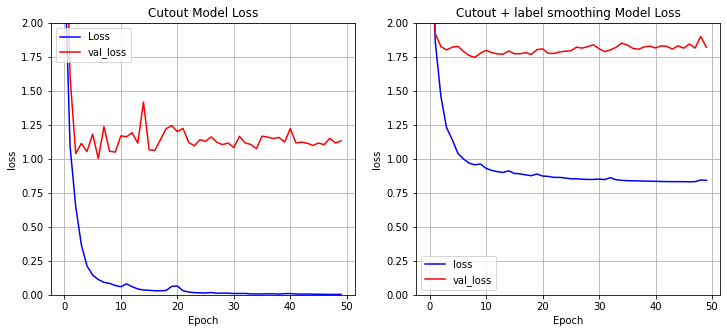

In [101]:
plt.figure(figsize = (12,5))

plt.subplot(1,2,1)
plt.plot(history_cutout_resnet50.history['loss'], 'b')
plt.plot(history_cutout_resnet50.history['val_loss'], 'r')
plt.title('Cutout Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Loss', 'val_loss'], loc='upper left')
plt.ylim(0.0, 2.0)  
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history_cutout_labelsmoothing_resnet50.history['loss'], 'b')
plt.plot(history_cutout_labelsmoothing_resnet50.history['val_loss'], 'r')
plt.title('Cutout + label smoothing Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='lower left')
plt.ylim(0.0, 2.0)  
plt.grid(True)

plt.show()

이미 loss가 0으로 수렴한 cutout 모델에 반해 cutout + label smoothing의 모델은 아직 더 낮아질 가능성이 있어 추가 학습이 가능할 것으로 보인다.   
(하지만 val loss가 높아지는 것으로 보아 overfitting이 발생할지도?)

## 회고
---

1. **생각보다 좋은 normal**
- train의 데이터 양이 많아서그런지? ResNet 모델이 좋아서 그런지? augmentation을 사용해도 큰 성능개선이 일어나지 않아서 놀랐다. 
- 논문을 보니 한 300 epoch 정도는 줘야 성능이 개선되는 것을 알 수 있다. 
- 생각해보니 Augment는 overfitting과 regularization을 높여 모델을 더 견고하게 만드는 용도니 높은 epoch에서 더이상 모델학습이 진행되지 않고 막혔을때 해결하기 위해서 사용할 것 같다. 
- 현업에선 20~100 epoch 정도가 아니라 모델을 튼튼하게 하기위해 더 높은 300 epoch 이상의 학습을 시킬텐데, 그땐 아무리 epoch을 늘려도 한계가 있으니까 그 지점을 돌파하는데 의미가 있는 것 같다.
- mixup 논문 결과  
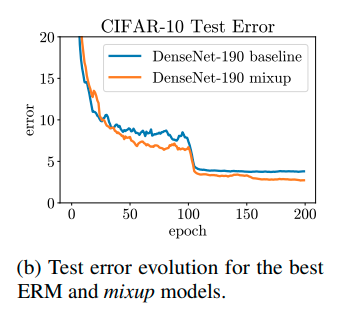
- cutmix 논문 결과   
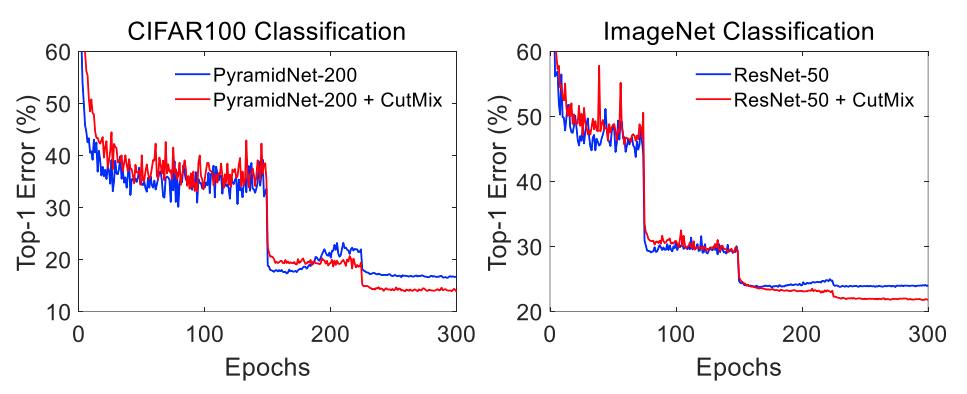

2. **추가 학습의 아쉬움**
- batch size도 바꿔서 데이터를 비교하고 싶었으나 자꾸 mixup, cutmix에서 터져서 해보지 못한게 아쉽다. 분명히 batch size의 영향도 있었을 텐데 해보지못해 찜찜하다.
- 어려운 augmentation을 하면 확실히 epoch을 늘릴수록 학습이 더 잘되길 하지만, 그에맞는 모델을 사용해야한다는 것을 알았다. 
- 그렇다면 후속실험으로 **같은 cutmix, epoch 200 조건에 ResNet 50, ResNet 100 두 모델간 비교**하는 것도 의미가 있을 것 같다. 다음에 요 조건으로 비교해보는 것도 해봐야겠다. 논문에서도 ResNet 과 PyramidNet 둘다 epoch가 진행됨에 따라 떨어지긴 했으나 y축 값을 보면 **ResNet 50보다 더 넓고 깊게 쌓은 Pyramid Net 200의 Error 값이 더 낮은 것**을 알 수 있다.  
- 추가 실험의 의욕이 뿜뿜한다! 다음엔 논문을 더 자세히 읽어서 추가실험의 틀을 확실히 짜놔야겠다.